# Using this to develop a function to create large amounts of pycbc data
want it to take a dictionary, containing the parameters to vary and their distributions

In [ ]:
import numpy as np
import torch
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
from pycbc.types import TimeSeries
from multiprocessing import Pool, cpu_count
from functools import partial
from typing import Dict, Callable, List, Tuple, Union
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [ ]:
def _validate_config(config: Dict[str, Callable]) -> None:
    """Validate configuration dictionary."""
    if not isinstance(config, dict):
        raise TypeError("config must be a dictionary")
    
    if not config:
        raise ValueError("config cannot be empty")
    
    for key, value in config.items():
        if not callable(value):
            raise TypeError(f"config['{key}'] must be callable (e.g., a distribution function)")
        
        try:
            test = value(size=2)
            if not isinstance(test, np.ndarray):
                raise TypeError(f"config['{key}']() must return numpy array")
        except Exception as e:
            raise ValueError(f"config['{key}'] failed test call: {e}")


def _generate_parameter_sets(config: Dict[str, Callable], num_samples: int) -> List[Dict]:
    """Generate all parameter combinations upfront."""
    param_arrays = {}
    for param_name, dist_func in config.items():
        param_arrays[param_name] = dist_func(size=num_samples)
    
    param_dicts = []
    for i in range(num_samples):
        param_dict = {name: float(values[i]) for name, values in param_arrays.items()}
        param_dicts.append(param_dict)
    
    return param_dicts


def _generate_single_waveform(params: Dict, time_resolution: float, approximant: str,
                              f_lower: float, detectors: List[str]) -> Dict:
    """Worker function to generate a single waveform and project to detectors."""
    try:
        hp, hc = get_td_waveform(
            approximant=approximant,
            mass1=params['mass1'],
            mass2=params['mass2'],
            spin1z=params.get('spin1z', 0.0),
            spin2z=params.get('spin2z', 0.0),
            inclination=params.get('inclination', 0.0),
            coa_phase=params.get('coa_phase', 0.0),
            delta_t=time_resolution,
            f_lower=f_lower
        )
        
        # Get sky location parameters (defaults to north pole and zero polarization)
        ra = params.get('ra', 0.0)
        dec = params.get('dec', np.pi/2)  # North pole
        polarization = params.get('polarization', 0.0)
        tc = params.get('tc', 0.0)
        
        # Project to detectors
        detector_signals = {}
        for det_name in detectors:
            detector = Detector(det_name)
            signal = detector.project_wave(hp, hc, ra, dec, polarization, method='lal')
            detector_signals[det_name] = signal
        
        result = {
            'success': True,
            'detectors': detector_signals,
            'params': params
        }
        
        return result
        
    except Exception as e:
        return {'success': False, 'error': str(e), 'params': params}


def _generate_waveforms_parallel(param_dicts: List[Dict],
                                time_resolution: float,
                                approximant: str,
                                f_lower: float,
                                num_workers: int,
                                show_progress: bool,
                                detectors: List[str]) -> List[Dict]:
    """Generate waveforms in parallel using multiprocessing."""
    worker_func = partial(_generate_single_waveform,
                          time_resolution=time_resolution,
                          approximant=approximant,
                          f_lower=f_lower,
                          detectors=detectors)
    
    with Pool(processes=num_workers) as pool:
        if show_progress:
            results = list(tqdm(
                pool.imap_unordered(worker_func, param_dicts, chunksize=100),
                total=len(param_dicts),
                desc="Generating waveforms"
            ))
        else:
            results = list(pool.imap_unordered(worker_func, param_dicts, chunksize=100))
    
    return results


def pycbc_data_generator(config: Dict[str, Callable],
                        num_samples: int,
                        time_resolution: float = 1/4096,
                        approximant: str = 'IMRPhenomXP',
                        f_lower: float = 40.0,
                        num_workers: int = None,
                        batch_size: int = 256,
                        chunk_size: int = 10000,
                        target_length: int = None,
                        allow_padding: bool = False,
                        train_split: float = 0.8,
                        val_split: float = 0.1,
                        show_progress: bool = True,
                        detectors: List[str] = None) -> Dict:
    """
    Generate PyCBC waveforms projected to detectors.
    Returns PyTorch DataLoaders for training, validation, and testing.
    
    Parameters
    ----------
    config : dict
        Dictionary mapping parameter names to numpy distribution functions.
        
        Required parameters:
        - 'mass1': Primary mass (solar masses)
        - 'mass2': Secondary mass (solar masses)
        
        Optional parameters:
        - 'spin1z', 'spin2z': Spin components
        - 'inclination', 'coa_phase': Orientation angles
        - 'ra': Right ascension (radians) - default: 0.0
        - 'dec': Declination (radians) - default: π/2 (north pole)
        - 'polarization': Polarization angle (radians) - default: 0.0
        - 'tc': Coalescence time - default: 0.0
        
    num_samples : int
        Total number of waveforms to generate
    time_resolution : float
        Time step (delta_t). Default: 1/4096
    approximant : str
        Waveform approximant. Default: 'IMRPhenomXP'
    f_lower : float
        Lower frequency cutoff (Hz). Default: 40.0
    num_workers : int
        Parallel processes. Default: min(cpu_count(), 8)
    batch_size : int
        DataLoader batch size. Default: 256
    chunk_size : int
        Process in chunks for memory. Default: 10000
    target_length : int
        Target length for padding/truncation. If None, uses max length.
        Only used if allow_padding=True.
    allow_padding : bool
        Allow zero-padding of waveforms to common length. Default: False.
        If False and waveforms have different lengths, raises ValueError.
        If True, pads shorter waveforms with zeros at the beginning.
    train_split : float
        Training fraction. Default: 0.8
    val_split : float
        Validation fraction. Default: 0.1
    detectors : list of str
        Detector names. Default: ['H1', 'L1']
    
    Returns
    -------
    dict with 'train_loader', 'val_loader', 'test_loader', 'metadata'
        
    Notes
    -----
    If ra, dec, or polarization are not provided in config, they default to:
    - ra = 0.0
    - dec = π/2 (north pole)
    - polarization = 0.0
    """
    # Validate inputs
    _validate_config(config)
    if num_samples <= 0:
        raise ValueError("num_samples must be positive")
    if not 0 < train_split < 1 or not 0 < val_split < 1:
        raise ValueError("train_split and val_split must be between 0 and 1")
    if train_split + val_split >= 1:
        raise ValueError("train_split + val_split must be < 1")
    
    if num_workers is None:
        num_workers = min(cpu_count(), 8)
    
    # Set default detectors
    if detectors is None:
        detectors = ['H1', 'L1']
    
    # Check which sky parameters are provided
    sky_params_provided = {
        'ra': 'ra' in config,
        'dec': 'dec' in config,
        'polarization': 'polarization' in config
    }
    
    if any(sky_params_provided.values()):
        print(f"Generating {num_samples} waveforms with projection to {detectors}")
        print(f"  Sky parameters: ra={'provided' if sky_params_provided['ra'] else 'default (0.0)'}, "
              f"dec={'provided' if sky_params_provided['dec'] else 'default (π/2)'}, "
              f"psi={'provided' if sky_params_provided['polarization'] else 'default (0.0)'}")
    else:
        print(f"Generating {num_samples} waveforms with projection to {detectors}")
        print(f"  Using default sky location: ra=0.0, dec=π/2 (north pole), psi=0.0")
    
    # Generate all parameters upfront
    param_dicts = _generate_parameter_sets(config, num_samples)
    
    # Process in chunks for memory efficiency
    all_successful = []
    all_failed = []
    num_chunks = (num_samples + chunk_size - 1) // chunk_size
    
    for chunk_idx in range(num_chunks):
        chunk_start = chunk_idx * chunk_size
        chunk_end = min(chunk_start + chunk_size, num_samples)
        chunk_params = param_dicts[chunk_start:chunk_end]
        
        if num_chunks > 1:
            print(f"\nChunk {chunk_idx + 1}/{num_chunks} ({len(chunk_params)} waveforms)...")
        
        # Generate waveforms with detector projection
        chunk_results = _generate_waveforms_parallel(
            chunk_params, time_resolution, approximant, f_lower, num_workers, show_progress, detectors
        )
        
        # Single pass: separate and accumulate
        for r in chunk_results:
            if r['success']:
                all_successful.append(r)
            else:
                all_failed.append(r)
        
        if num_chunks > 1:
            print(f"  Chunk: {len([r for r in chunk_results if r['success']])} successful")
    
    if not all_successful:
        raise RuntimeError("No waveforms were successfully generated!")
    
    num_success = len(all_successful)
    num_failed = len(all_failed)
    print(f"\nGeneration complete: {num_success} successful, {num_failed} failed")
    
    # Extract everything in one pass with pre-allocated arrays
    print(f"\nProcessing {num_success} waveforms...")
    
    # Get parameter names and detector names
    param_names = list(all_successful[0]['params'].keys())
    num_params = len(param_names)
    detector_names = list(all_successful[0]['detectors'].keys())
    num_detectors = len(detector_names)
    
    print(f"  Detector channels: {detector_names}")
    
    # Pre-scan for lengths
    lengths = np.array([len(w['detectors'][detector_names[0]]) for w in all_successful])
    min_len, max_len = lengths.min(), lengths.max()
    
    print(f"  Waveform lengths: min={min_len}, max={max_len}")
    
    # Check if padding is needed
    if min_len != max_len:
        if not allow_padding:
            raise ValueError(
                f"Waveforms have variable lengths (min={min_len}, max={max_len}). "
                f"This happens because PyCBC generates waveforms of different durations "
                f"depending on the binary parameters (especially masses). "
                f"\n\nTo handle this, set allow_padding=True to zero-pad shorter waveforms. "
                f"Padding adds zeros at the beginning (before the signal), which is "
                f"physically meaningful and standard practice in GW analysis."
            )
        else:
            print(f"  WARNING: Variable lengths detected. Applying zero-padding.")
            print(f"  Padding will be added at the beginning (before signal starts).")
    
    # Determine target length
    if target_length is None:
        target_length = max_len
    elif target_length < max_len:
        print(f"  WARNING: target_length ({target_length}) < max length ({max_len}). Will truncate!")
    
    print(f"  Target length: {target_length}")
    
    # Pre-allocate arrays
    signal_array = np.zeros((num_success, num_detectors, target_length), dtype=np.float32)
    param_array = np.zeros((num_success, num_params), dtype=np.float32)
    
    # Single pass: extract everything
    for i, w in enumerate(all_successful):
        # Extract detector signals
        for j, det_name in enumerate(detector_names):
            signal_data = w['detectors'][det_name].numpy()
            current_len = len(signal_data)
            
            # Pad or truncate
            if current_len <= target_length:
                # Pad at beginning (zero-padding before signal starts)
                start_idx = target_length - current_len
                signal_array[i, j, start_idx:] = signal_data
            else:
                # Truncate (keep end where merger happens)
                signal_array[i, j] = signal_data[-target_length:]
        
        # Extract parameters
        for j, name in enumerate(param_names):
            param_array[i, j] = w['params'][name]
    
    print(f"  Converting to PyTorch tensors...")
    
    # Convert to PyTorch
    X = torch.from_numpy(signal_array)  # (N, num_detectors, T)
    y = torch.from_numpy(param_array)    # (N, num_params)
    
    print(f"  Tensors: X={X.shape}, y={y.shape}")
    
    # Create dataset and split
    dataset = TensorDataset(X, y)
    total_size = len(dataset)
    train_size = int(train_split * total_size)
    val_size = int(val_split * total_size)
    test_size = total_size - train_size - val_size
    
    train_data, val_data, test_data = random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    print(f"  Splits: train={train_size}, val={val_size}, test={test_size}")
    
    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    print(f"\nReady! DataLoaders with batch_size={batch_size}")
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'metadata': {
            'parameter_names': param_names,
            'num_samples': num_success,
            'num_failed': num_failed,
            'waveform_shape': tuple(X.shape[1:]),
            'channels': detector_names,
            'train_size': train_size,
            'val_size': val_size,
            'test_size': test_size,
            'batch_size': batch_size,
            'time_resolution': time_resolution,
            'approximant': approximant,
            'f_lower': f_lower,
            'detectors': detector_names,
            'target_length': target_length,
            'original_length_range': (int(min_len), int(max_len)),
            'chunk_size': chunk_size,
            'sky_params_provided': sky_params_provided,
            'allow_padding': allow_padding
        }
    }

In [3]:
# Example 1: Basic usage with default sky location (north pole, zero polarization)
config = {
    'mass1': lambda size: np.random.uniform(10, 50, size=size),
    'mass2': lambda size: np.random.uniform(10, 50, size=size),
    'spin1z': lambda size: np.random.uniform(-0.5, 0.5, size=size),
}

# Generate with H1 and L1 projection (default detectors)
# Uses default: ra=0.0, dec=π/2 (north pole), polarization=0.0
result = pycbc_data_generator(
    config, 
    num_samples=100, 
    batch_size=16, 
    num_workers=2
)

# Access the loaders
train_loader = result['train_loader']
val_loader = result['val_loader']
test_loader = result['test_loader']

# Print metadata
print(f"\nMetadata:")
for key, value in result['metadata'].items():
    print(f"  {key}: {value}")

# Show first batch
print(f"\nFirst training batch:")
for waveforms, params in train_loader:
    print(f"  Waveforms shape: {waveforms.shape}")  # (batch, 2, time) - H1 and L1 channels
    print(f"  Parameters shape: {params.shape}")
    print(f"  H1 channel: {waveforms[0, 0, :5]}")
    print(f"  L1 channel: {waveforms[0, 1, :5]}")
    break

Generating 100 waveforms with projection to ['H1', 'L1']
  Using default sky location: ra=0.0, dec=π/2 (north pole), psi=0.0


Generating waveforms: 100%|██████████| 100/100 [00:16<00:00,  5.99it/s]



Generation complete: 100 successful, 0 failed

Processing 100 waveforms...
  Detector channels: ['H1', 'L1']
  Lengths: min=2162, max=5188, target=5188
  Converting to PyTorch tensors...
  Tensors: X=torch.Size([100, 2, 5188]), y=torch.Size([100, 3])
  Splits: train=80, val=10, test=10

Ready! DataLoaders with batch_size=16

Metadata:
  parameter_names: ['mass1', 'mass2', 'spin1z']
  num_samples: 100
  num_failed: 0
  waveform_shape: (2, 5188)
  channels: ['H1', 'L1']
  train_size: 80
  val_size: 10
  test_size: 10
  batch_size: 16
  time_resolution: 0.000244140625
  approximant: IMRPhenomXP
  f_lower: 40.0
  detectors: ['H1', 'L1']
  target_length: 5188
  original_length_range: (2162, 5188)
  chunk_size: 10000
  sky_params_provided: {'ra': False, 'dec': False, 'polarization': False}

First training batch:
  Waveforms shape: torch.Size([16, 2, 5188])
  Parameters shape: torch.Size([16, 3])
  H1 channel: tensor([0., 0., 0., 0., 0.])
  L1 channel: tensor([0., 0., 0., 0., 0.])


  Waveforms shape: torch.Size([16, 2, 5982])
  Parameters shape: torch.Size([16, 3])
  H1 channel: tensor([0., 0., 0., 0., 0.])
  L1 channel: tensor([0., 0., 0., 0., 0.])


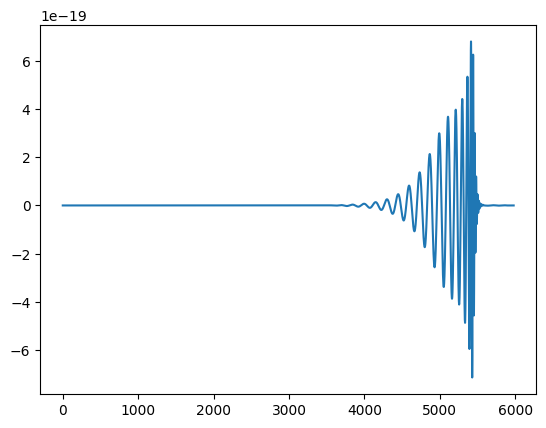

In [15]:
for waveforms, params in train_loader:
    print(f"  Waveforms shape: {waveforms.shape}")  # (batch, 2, time) - H1 and L1 channels
    print(f"  Parameters shape: {params.shape}")
    print(f"  H1 channel: {waveforms[0, 0, :5]}")
    print(f"  L1 channel: {waveforms[0, 1, :5]}")
    plt.plot(waveforms[0, 0, :], label='H1')
    break

In [ ]:
# Example 2: Including sky location parameters (random positions)
config_with_sky = {
    'mass1': lambda size: np.random.uniform(10, 50, size=size),
    'mass2': lambda size: np.random.uniform(10, 50, size=size),
    'spin1z': lambda size: np.random.uniform(-0.5, 0.5, size=size),
    # Add sky location parameters for varying detector response
    'ra': lambda size: np.random.uniform(0, 2*np.pi, size=size),
    'dec': lambda size: np.random.uniform(-np.pi/2, np.pi/2, size=size),
    'polarization': lambda size: np.random.uniform(0, 2*np.pi, size=size),
}

# Generate with random sky locations
result_sky = pycbc_data_generator(
    config_with_sky, 
    num_samples=100, 
    batch_size=16,
    num_workers=2
)

print(f"\nWith random sky locations:")
print(f"  Sky params provided: {result_sky['metadata']['sky_params_provided']}")
for waveforms, params in result_sky['train_loader']:
    print(f"  Waveforms shape: {waveforms.shape}")
    print(f"  Parameters include: {result_sky['metadata']['parameter_names']}")
    break

In [ ]:
# Example 3: Using three detectors (H1, L1, V1)
config_three = {
    'mass1': lambda size: np.random.uniform(10, 50, size=size),
    'mass2': lambda size: np.random.uniform(10, 50, size=size),
    'spin1z': lambda size: np.random.uniform(-0.5, 0.5, size=size),
    'ra': lambda size: np.random.uniform(0, 2*np.pi, size=size),
    'dec': lambda size: np.random.uniform(-np.pi/2, np.pi/2, size=size),
    'polarization': lambda size: np.random.uniform(0, 2*np.pi, size=size),
}

# Generate with three detectors
result_three = pycbc_data_generator(
    config_three, 
    num_samples=50, 
    batch_size=16,
    detectors=['H1', 'L1', 'V1'],  # Add Virgo
    num_workers=2
)

print(f"\nWith three detectors:")
for waveforms, params in result_three['train_loader']:
    print(f"  Waveforms shape: {waveforms.shape}")  # (batch, 3, time)
    print(f"  Channels: {result_three['metadata']['channels']}")
    print(f"  H1: {waveforms[0, 0, :5]}")
    print(f"  L1: {waveforms[0, 1, :5]}")
    print(f"  V1: {waveforms[0, 2, :5]}")
    break

## Example 4: Large-scale production usage

For generating hundreds of thousands of waveforms:

```python
# Define comprehensive parameter distributions
large_config = {
    'mass1': lambda size: np.random.uniform(10, 100, size=size),
    'mass2': lambda size: np.random.uniform(10, 100, size=size),
    'spin1z': lambda size: np.random.uniform(-0.9, 0.9, size=size),
    'spin2z': lambda size: np.random.uniform(-0.9, 0.9, size=size),
    'inclination': lambda size: np.random.uniform(0, np.pi, size=size),
    'coa_phase': lambda size: np.random.uniform(0, 2*np.pi, size=size),
    # Sky location parameters (optional - will use defaults if omitted)
    'ra': lambda size: np.random.uniform(0, 2*np.pi, size=size),
    'dec': lambda size: np.random.uniform(-np.pi/2, np.pi/2, size=size),
    'polarization': lambda size: np.random.uniform(0, 2*np.pi, size=size),
}

# Generate 100,000 waveforms with H1 and L1 detector projection
# Takes ~2-3 hours on 8-core system
result_large = pycbc_data_generator(
    large_config,
    num_samples=100000,
    batch_size=256,
    num_workers=8,
    chunk_size=10000,
    detectors=['H1', 'L1']
)

# Directly use in training
train_loader = result_large['train_loader']
val_loader = result_large['val_loader']
test_loader = result_large['test_loader']

# Train with JHPY.py functions
# from JHPY import ParameterPredictor, train_predictor_model
# model = ParameterPredictor()
# train_predictor_model(model, optimizer, loss_fn, n_epochs, train_loader, val_loader)
```

**Key features:**
- Always projects to detectors (H1 and L1 by default)
- If ra/dec/polarization not in config, uses defaults:
  - ra = 0.0
  - dec = π/2 (north pole)
  - polarization = 0.0
- Output shape: (batch, num_detectors, time)
- Automatic train/val/test splitting (80/10/10)
- Memory-efficient chunked processing
- Ready for JHPY.py training functions

In [ ]:
large_config = {
    'mass1': lambda size: np.random.uniform(10, 100, size=size),
    'mass2': lambda size: np.random.uniform(10, 100, size=size),
    'spin1z': lambda size: np.random.uniform(-0.9, 0.9, size=size),
    'spin2z': lambda size: np.random.uniform(-0.9, 0.9, size=size),
    'inclination': lambda size: np.random.uniform(0, np.pi, size=size),
    'coa_phase': lambda size: np.random.uniform(0, 2*np.pi, size=size),
}

# Generate 100,000 waveforms (will take 2-3 hours on 8-core system)
results_large = pycbc_data_generator(
    large_config, 
    datapoints_per_param=100000,
    num_workers=8,
    chunk_size=10000
)

# Save to disk
arrays_large = extract_waveform_arrays(results_large)
np.savez_compressed('waveforms_100k.npz', **arrays_large)

Generating 100000 waveforms using 8 workers...
Processing chunk 1/10...


Generating waveforms:  71%|███████   | 7101/10000 [04:39<01:55, 25.21it/s]